<a href="https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/Colab_Demo_%E8%A8%AD%E8%A8%88%E4%BD%A0%E7%9A%84%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF%20Gradio%20%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

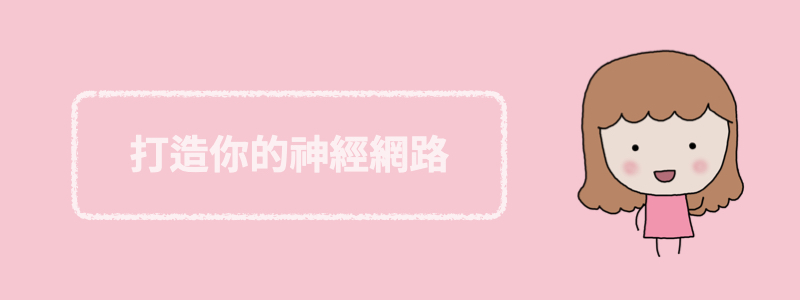


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/Colab_Demo_%E8%A8%AD%E8%A8%88%E4%BD%A0%E7%9A%84%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF%20Gradio%20%E7%89%88.ipynb)

我們終於要開始做生命中第一個神經網路...

這是 TensorFlow 2 的版本, TensorFlow 完全融入一個叫 Keras 的套件, 整個變成非常容易使用的深度學習框架。

## 1. 讀入套件

這裡我們讀入一些套件, 今天暫時不要理會細節。

In [1]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt

# 神經網路方面
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

## 2. 讀入 MNIST 數據庫

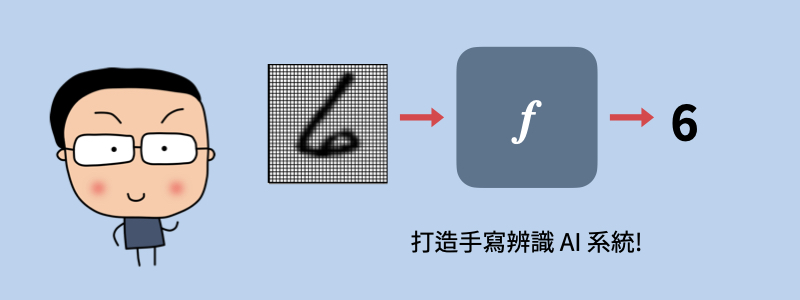

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 2.1 由 Keras 讀入 MNIST

Keras 很貼心的幫我們準備好 MNIST 數據庫, 我們可以這樣讀進來 (第一次要花點時間)。

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


我們來看看訓練資料是不是 6 萬筆、測試資料是不是有 1 筆。

In [3]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


### 2.2 數據庫的內容

每筆輸入 (x) 就是一個手寫的 0-9 中一個數字的圖檔, 大小為 28x28。而輸出 (y) 當然就是「正確答案」。我們來看看編訓練資料的 x 輸入、輸出的部份分別長什麼樣子。

In [4]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'本資料 y 給定的答案為: {y_train[n]}')

In [5]:
interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

In [6]:
def show_data(n = 100):
    X = x_train[n]
    print(X)

In [7]:
interact_manual(show_data, n=(0,59999));

interactive(children=(IntSlider(value=100, description='n', max=59999), Button(description='Run Interact', sty…

### 2.3 輸入格式整理

我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 `reshape` 調校一下。

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
x_test.shape

(10000, 28, 28)

In [10]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

In [11]:
x_train[87]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### 2.4 輸出格式整理
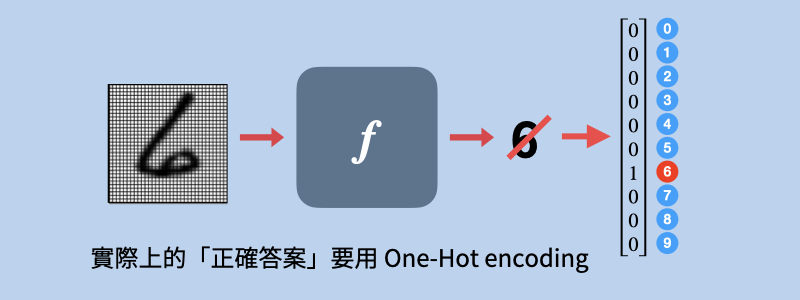

我們可能會想, 我們想學的函數是這樣的型式:

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}$$

其實這樣不太好! 為什麼呢? 比如說我們的輸入 x 是一張 0 的圖, 因為我們訓練的神經網路總會有點誤差, 所以可能會得到:

$$\hat{f}(x) = 0.5$$

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像啊。換句話說分類的問題這樣做其實不合理!

於是我們會做 "1-hot enconding", 也就是

* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
* 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0]

等等。因為分類問題基本上都要做這件事, Keras 其實已幫我們準備好套件!

In [12]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

我們來看看剛剛某號數據的答案。

In [13]:
n = 87
y_train[n]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

和我們想的一樣! 至此我們可以打造我們的神經網路了。

## 3. 打造第一個神經網路

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

### 3.1 決定神經網路架構、讀入相關套件

假如我們要用 ReLU 當激發函數, 要設計神經網路, 只差要指定多少個隱藏層、每層多少個神經元就好了!

設計完了基本上就是告訴 TensorFlow, 我們的想法就可以了!

In [ ]:
#@title 設計你的神經網路
隱藏層數 = 3 #@param{type:"integer"}
神經元1 =  0#@param{type:"integer"}
神經元2 = 0 #@param{type:"integer"}
神經元3 = 0 #@param{type:"integer"}
神經元4 = 0 #@param{type:"integer"}
神經元5 = 0 #@param{type:"integer"}


### 3.2 建構我們的神經網路

和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是我們打開一個空的神經網路。

In [14]:
model = Sequential()

我們每次用 `add` 去加一層, 從第一個隱藏層開始。而第一個隱藏層因為 TensorFlow 當然猜不到輸入有 784 個 features, 所以我們要告訴它。

In [15]:
model.add(Dense(20, input_dim=784, activation='relu'))

第二層開始就不用再說明輸入神經元個數 (因為就是前一層神經元數)。

In [16]:
model.add(Dense(20, activation='relu'))

In [17]:
model.add(Dense(20, activation='relu'))

輸出有 10 個數字, 所以輸出層的神經元是 10 個! 而如果我們的網路輸出是 

$$(y_1, y_2, \ldots, y_{10})$$

我們還希望

$$\sum_{i=1}^{10} y_i = 1$$

這可能嗎, 結果是很容易, 就用 `softmax` 當激發函數就可以!!

In [18]:
model.add(Dense(10, activation='softmax'))

至此我們的第一個神經網路就建好了!

### 3.3 組裝

和之前比較不一樣的是我們還要做 `compile` 才正式把我們的神經網路建好。你可以發現我們還需要做幾件事:

* 決定使用的 loss function, 一般是 `mse`
* 決定 optimizer, 我們用標準的 SGD
* 設 learning rate

為了一邊訓練一邊看到結果, 我們加設

    metrics=['accuracy']
    
本行基本上和我們的神經網路功能沒有什麼關係。

In [20]:
model.compile(loss='mse', optimizer=SGD(learning_rate=0.087), metrics=['accuracy'])

## 4. 檢視我們的神經網路

我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

### 4.1 看 model 的 summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 16,750
Trainable params: 16,750
Non-trainable params: 0
_________________________________________________________________


很快算算參數數目和我們想像是否是一樣的!

## 5. 訓練你的第一個神經網路

恭喜! 我們完成了第一個神經網路。現在要訓練的時候, 你會發現不是像以前沒頭沒腦把訓練資料送進去就好。這裡我們還有兩件事要決定:

* 一次要訓練幾筆資料 (`batch_size`), 我們就 100 筆調一次參數好了
* 這 6 萬筆資料一共要訓練幾次 (`epochs`), 我們訓練個 10 次試試

於是最精彩的就來了。你要有等待的心理準備...

In [22]:
model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
600/600 [==============================] - 4s 2ms/step - loss: 0.0892 - accuracy: 0.1038
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0855 - accuracy: 0.1593
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0808 - accuracy: 0.3638
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0674 - accuracy: 0.4868
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0477 - accuracy: 0.6993
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0306 - accuracy: 0.8251
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0230 - accuracy: 0.8566
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.8731
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.8855
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0164 - accuracy: 0.8947

## 6. 試用我們的結果

我們來用比較炫的方式來看看可愛的神經網路學習成果。對指令有問題可以參考《少年Py的大冒險：成為Python數據分析達人的第一門課》。

In [23]:
loss, acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0150 - accuracy: 0.9029


In [24]:
print(f"測試資料正確率 {acc*100:.2f}%")

測試資料正確率 90.29%


In [25]:
from ipywidgets import interact_manual

我們 "predict" 放的是我們神經網路的學習結果。做完之後用 argmax 找到數值最大的那一項。

In [26]:
predict = np.argmax(model.predict(x_test), axis=-1)

In [27]:
predict

array([7, 2, 1, ..., 4, 8, 6])

不要忘了我們的 `x_test` 每筆資料已經換成 784 維的向量, 我們要整型回 28x28 的矩陣才能當成圖形顯示出來!

In [28]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

神經網路判斷為: 5


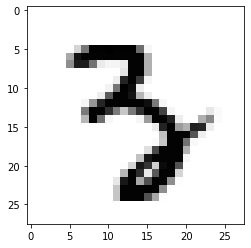

In [29]:
test(87)

In [30]:
interact_manual(test, 測試編號=(0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「總評量」。

In [31]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0150 - accuracy: 0.9029


In [32]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.015002136118710041
正確率 0.902899980545044


## 7. 訓練好的神經網路存起來!

如果對訓練成果滿意, 我們當然不想每次都再訓練一次! 我們可以把神經網路的架構和訓練好的參數都存起來, 以供日後使用!

在 Colab 上, 我們要先連到自己的 Google Drive。

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


再來是 cd 到你的資料夾中, 我們通常是放到自己 Colab Notebooks 中, 自然你可以指定其他的資料夾。

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


日後要讀回來就是要用 `tf.keras.models` 的 `load_model`:

```from tensorflow.kears.models import load_model```

連上自己的 Google Drive, cd 進去原來存的資料夾。

```model = load_model('my_model')```

就可以了!


### 8. 用 Gradio 來展示

In [33]:
!pip install gradio

     |████████████████████████████████| 2.4MB 25.4MB/s 
     |████████████████████████████████| 215kB 54.0MB/s 
     |████████████████████████████████| 1.9MB 54.7MB/s 
     |████████████████████████████████| 962kB 40.5MB/s 
     |████████████████████████████████| 3.2MB 40.6MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=d163a268b4059033aa7dddc9aac604b1193e90af7b70f2eb6db448291c85c760
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=43d9b200564391402342902a9b7b4660520d2c96dd018299bbeb9c4e9984518c
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
Successfully built ffmpy flask-cachebuster


In [34]:
import gradio as gr

In [35]:
def recognize_digit(img):
  img = img.reshape(1,784)
  prediction = model.predict(img).flatten()
  labels = list('0123456789')
  return {labels[i]: float(prediction[i]) for i in range(10)}

In [36]:
gr.Interface(fn=recognize_digit, inputs="sketchpad", outputs="label").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://32792.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://32792.gradio.app')